In [2]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [3]:
# 设置虚拟屏幕
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [4]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

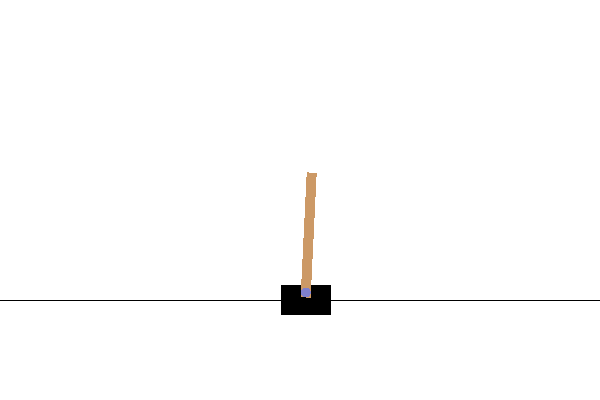

In [6]:
# 加载环境
env = suite_gym.load('CartPole-v0')
env.reset()
PIL.Image.fromarray(env.render())

## 观察tf_agents环境的各个参数

In [9]:
print("Observation_spec:")
print(env.time_step_spec().observation)

Observation_spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])


In [10]:
print("Reward Spec:")
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [11]:
print("Action Spec")
print(env.action_spec())

Action Spec
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [13]:
# step_type 只有三个取值：
# 0：最初状态
# 1：中间状态
# 2：结束状态
time_step = env.reset()
print('Time Step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print("Next step:")
print(next_time_step)

Time Step:
TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.02584048,  0.04392974,  0.01378801, -0.00287406], dtype=float32))
Next step:
TimeStep(step_type=array(1, dtype=int32), reward=array(1., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.02671907,  0.23885126,  0.01373053, -0.291175  ], dtype=float32))


In [15]:
# In practice ， 一般实例化两个环境， 一个用于训练， 一个用于评估

# 下面两个环境都是 pure python 的！！！
train_py_env = suite_gym.load('CartPole-v0')
eval_py_env = suite_gym.load('CartPole-v0')

# 然后对他们使用 tf_py_environment 进行包裹转换成Tensroflow的
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [16]:
# 这个教程使用DQN

# 创建 QNetwork
fc_layer_params = (100,)
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [17]:
# 构造 agent
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DdqnAgent(
    # time_step_spec()包含的是 agent 在各个时间步的状态#空间#信息（shape，最大值，最小值等）
    # 不是具体当前的具体信息
    # 包含:
    #     step_type
    #     reward
    #     discount
    #     observation
    train_env.time_step_spec(),
    # action_spec() 关注动作空间信息
    train_env.action_spec(),
    q_network = q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()


In [23]:
agent.collect_data_spec

Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)), action=BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))

In [19]:
# 指定 policy

# 用于评估和部署的主要策略
eval_policy = agent.policy

# 用于数据收集的策略
collect_policy = agent.collect_policy

# 也可以独立于 Agent 创建策略
# e.g. 使用random_tf_policy创建随机策略
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [20]:
# 从 policy 获取动作，使用policy.action(time_step) 返回一个三元组
# (action, state, info)
# action是 policy 决定采用的动作， state 和 info 貌似作用不大
# e.g.
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('CartPole-v0'))
time_step = example_environment.reset()
random_policy.action(time_step)


PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>, state=(), info=())

In [21]:
# 指标和评估
# 一般而言 评估是采用平均回报
# 运行几个episode之后平均一下

def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

In [22]:
# 在 随机策略上测试baseline
compute_avg_return(eval_env, random_policy, num_eval_episodes)

21.1